# Setup
For now we'll just be importing a few things we'll definitely need 

In [225]:
import geopandas as gp
import pandas as pd

## GTFS Import: Where are our public transport stops?

Importing the GTFS feed with all the stops and stations to display them on a map. This step will allow a first quality assesment of the data. As GTFS is basically a relational database made up of various comma-separated text files, we'll first need to make sure pandas and geopandas can read them properly. The first file we'll look at is `stops.txt`, because it is the only that actually contains geo-referenced data, the stop locations. All the other files in the GTFS feed are referencing these stops to create relations between them

In [226]:
stops_df = pd.read_csv("2022-07-26_RNV_GTFS_Schedule\\stops.txt")
stops_df.to_csv("stops.csv")

Now we have the GTFS stop file as a .csv. we need to make sure the columns stop_lon, and stop_lat are converted to a format that geopandas can work with

In [227]:
stops_gdf = gp.GeoDataFrame(stops_df, geometry=gp.points_from_xy(stops_df.stop_lon, stops_df.stop_lat))
stops_gdf.head()

,stop_id,stop_name,stop_lat,stop_lon,location_type,platform_code,geometry
0,11601,Bad Dürkheim Bahnhof,49.461528,8.170429,0,1,POINT (8.17043 49.46153)
1,13401,Bad Dürkheim Ost,49.463490,8.185206,0,1,POINT (8.18521 49.46349)
2,13402,Bad Dürkheim Ost,49.463420,8.184254,0,2,POINT (8.18425 49.46342)
3,51501,Dossenheim Bahnhof,49.448191,8.670171,0,1,POINT (8.67017 49.44819)
4,51502,Dossenheim Bahnhof,49.448553,8.669533,0,2,POINT (8.66953 49.44855)


## Mapping our Dataset
Let's try and plot this

### A Plot on simple Axes

<AxesSubplot:>

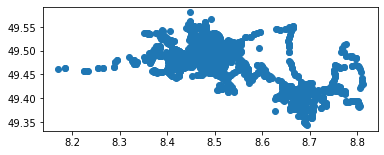

In [228]:
stops_gdf.plot()

Well we do have a sensible plot, but we might need some more data to really read it, for that we'll import folium to give us some more map options.

### Putting Our Dataset on a Map

In [229]:
import folium
#creating the map from Open Street Maps
map = folium.Map(location = [49.46531, 8.54317], tiles='OpenStreetMap' , zoom_start = 11)
#and adding out geopandas frame

stops_gdf.explore("platform_code", m=map)


We have a map. This won't render on GitHub however. To see what i've been doing, download the `stops_map.html` file from the repository and open it in your browser.

This however took me some fiddling, because at first I did not have the right geopandas version installed for the `.explore()` method to work. And then I thought i had some wild crs issues, that i valiantly tried to fix, when i had just accidentally swapped the `x,y` to `stop_lon, stop_lat` tranformation. This caused two issues:
+ the extent of the geometry was in the sub one meter range
+ for reasons that were inexplicable to me the stops were all located somewhere in northern Somalia 

I was able to fix the first issue by setting the Coordinate Reference System (CRS) to WGS 84 (`stops_gdf.set_crs(epsg=4326, inplace=True)`), but this left me with stops in Somalia, rotated by 90°. Only then it dawned on me that i had flipped x and y earlier. The CRS of `stops_gdf` is likely still set to `none` and we should set it to avoid future issues.

In [230]:
print(stops_gdf.crs)

None


In [231]:
stops_gdf.set_crs(epsg=4326, inplace=True)
print(stops_gdf.crs)

epsg:4326


Because this map won't render correctly on GitHub we might also need to provide an html file, that then can be either run locally or hosted somewhere. 

In [232]:
# Renders the map to an HTML file and displays it in an embed
def embed_map(m, title):
    from IPython.display import IFrame
    m.save(f'{title}.html')
    return IFrame(f'[{title}.html', width='100%', height='750px')

Little Aside because i didn't do this earlier, and just manually took one of the data points by hand earlier

In [233]:
# i want a better center point for the folium map
stops_gdf.dissolve().centroid
#this will be a bit rough, because it is in a geographic CRS but it will do for my purpose of selecting a good midpoint for the folium map, for now i'll just manually enter that.

C:\Users\chwiggy\AppData\Local\Temp\ipykernel_12992\2900823740.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  stops_gdf.dissolve().centroid


0    POINT (8.54317 49.46531)
dtype: geometry

In [234]:
#exporting a html file
embed_map(stops_gdf.explore("platform_code", m=map), "stops_map")

### Interpretation
So looking at this dataset on the map, gives us a few first insights. This dataset does indeed offer correct stop locations for our area. There are, however an issue:
This GTFS-Dataset comes from a municipal bus and tram operator (RNV), and does not includes stops where public transport not operated by RNV buses or trams. Therefore it excludes both local and regional rail services run by DB and SWEG, as well as overland bus routes operated by BRN, DB, and SWEG and others.

We could look at a similar dataset by the local linked transport system VRN. This dataset likely is quite a bit larger and would require more processing time. As this is a proof of concept and analysis will focus on Heidelberg proper, this is a tradeoff I am willing to make for now. (The `custom.py` script should work on any GTFS feed anyhow). For our reachability analysis this might also limit what time-limits will be sensible to look at.

## Useful Boundaries
As I want to restrict the extent of this analysis to the city of Heidelberg, we need a set of boundaries. Heidelberg as a city is "kreisfrei" so we can get it's boundaries by importing shape files of county boundaries in Baden-Württemberg from LGL (2022).

In [235]:
counties_gdf = gp.read_file("OD_AX_Gebiet_Kreis.zip")
counties_gdf.head()

,Name,Schlüssel,geometry
0,Lörrach,08336,"POLYGON ((418041.472 5303150.731, 418191.092 5..."
1,Waldshut,08337,"POLYGON ((429506.039 5301007.365, 429587.627 5..."
2,Bodenseekreis,08435,"POLYGON ((519633.579 5303228.310, 519659.499 5..."
3,Ravensburg,08436,"POLYGON ((541842.092 5316813.214, 541918.492 5..."
4,Breisgau-Hochschwarzwald,08315,"POLYGON ((395079.924 5329317.620, 395137.351 5..."


In [236]:
#we only need Heidelberg
county_gdf = counties_gdf.loc[counties_gdf["Name"] == "Heidelberg"]
county_gdf

,Name,Schlüssel,geometry
40,Heidelberg,08221,"POLYGON ((482222.762 5478563.654, 482274.881 5..."


We can now use this to restrict our stop data

In [237]:
#first lets check the crs
county_gdf.crs

<Projected CRS: PROJCS["ETRS89_UTM_zone_32N",GEOGCS["ETRS89",DATUM ...>
Name: ETRS89_UTM_zone_32N
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 32N
- method: Transverse Mercator
Datum: European Terrestrial Reference System 1989
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

We need the CRS to be the same, and as we'll need geographic coordinates later, we should change the crs of our `county_gdf`

In [238]:
county_gdf = county_gdf.to_crs("epsg:4326")
county_gdf

,Name,Schlüssel,geometry
40,Heidelberg,08221,"POLYGON ((8.75469 49.45947, 8.75541 49.45885, ..."


In [239]:
stops_clipped = gp.clip(stops_gdf, county_gdf)
stops_clipped.head()

,stop_id,stop_name,stop_lat,stop_lon,location_type,platform_code,geometry
475,131711,Kreuzgrundweg,49.431771,8.747462,0,B,POINT (8.74746 49.43177)
1990,640911,Turnerbrunnen,49.431789,8.705376,0,A,POINT (8.70538 49.43179)
126,113301,Burgstraße,49.434353,8.682244,0,A,POINT (8.68224 49.43435)
523,136411,Peterstaler Straße,49.434628,8.749088,0,B,POINT (8.74909 49.43463)
524,136412,Peterstaler Straße,49.434686,8.749214,0,A,POINT (8.74921 49.43469)


In [240]:
#I want a centre point for this dataset again, so I'll try the methods i scripted
import custom 
centre = custom.convert_for_folium(custom.find_centre_rough(stops_clipped))
centre

c:\Users\chwiggy\Documents\Studium\2022-04-01_UniHD_SummerTerm_2022\TTTAGIS\2022-08-31_FinalAssignment\custom.py:16: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center_lon_lat = geodataframe.dissolve().centroid


[49.404901276691724, 8.694269560150385]

In [241]:
#lets put it on a map again
map_HD = folium.Map(location=centre, tiles='OpenStreetMap', zoom_start = 12)
stops_clipped.explore(m=map_HD)

Now that we have our public transport stops we need the second part of our data set

## Hospital Locations
To find all hospitals we're using the ohsome API

In [242]:
import requests

# we need our county as a geoJSON
boundary = county_gdf.to_json()

In [243]:
URL = 'https://api.ohsome.org/v1/elements/geometry'
data = {"bpolys": boundary,"time": "2022-07-26", "filter": "amenity=hospital and type:node"}
ohsome_response = requests.post(URL, data)

In [244]:
print(ohsome_response.json())

{'attribution': {'url': 'https://ohsome.org/copyrights', 'text': '© OpenStreetMap contributors'}, 'apiVersion': '1.7.0', 'type': 'FeatureCollection', 'features': [{'type': 'Feature', 'geometry': {'type': 'Point', 'coordinates': [8.6870861, 49.4096905]}, 'properties': {'@osmId': 'node/582616967', '@snapshotTimestamp': '2022-07-26T00:00:00Z'}}, {'type': 'Feature', 'geometry': {'type': 'Point', 'coordinates': [8.6857745, 49.409413]}, 'properties': {'@osmId': 'node/582617360', '@snapshotTimestamp': '2022-07-26T00:00:00Z'}}, {'type': 'Feature', 'geometry': {'type': 'Point', 'coordinates': [8.6878988, 49.4100169]}, 'properties': {'@osmId': 'node/582623059', '@snapshotTimestamp': '2022-07-26T00:00:00Z'}}, {'type': 'Feature', 'geometry': {'type': 'Point', 'coordinates': [8.6538078, 49.4136043]}, 'properties': {'@osmId': 'node/678470357', '@snapshotTimestamp': '2022-07-26T00:00:00Z'}}, {'type': 'Feature', 'geometry': {'type': 'Point', 'coordinates': [8.6663847, 49.4155972]}, 'properties': {'@os

In [245]:
hospitals_gdf = gp.GeoDataFrame.from_features(ohsome_response.json())
hospitals_gdf.head()

,geometry,@osmId,@snapshotTimestamp
0,POINT (8.68709 49.40969),node/582616967,2022-07-26T00:00:00Z
1,POINT (8.68577 49.40941),node/582617360,2022-07-26T00:00:00Z
2,POINT (8.68790 49.41002),node/582623059,2022-07-26T00:00:00Z
3,POINT (8.65381 49.41360),node/678470357,2022-07-26T00:00:00Z
4,POINT (8.66638 49.41560),node/2343179537,2022-07-26T00:00:00Z


In [246]:
map_HD = folium.Map(location=centre, tiles='OpenStreetMap', zoom_start = 12)
hospitals_gdf.explore(m=map_HD)

Exploring this map of hospital locations, there are a few unexpected issues. On one hand we have amemities that are classified as hospitals, but provide specialised healthcare like the two psychiatric hospital markers in Bergheim. On the other hand we are missing some amenities that are hospitals but are not associated with a single node in the data set like the hospital St. Vincentius in the Altstadt.

In [247]:
data = {"bpolys": boundary,"time": "2022-07-26", "filter": "healthcare=hospital and healthcare:speciality!=*"}
ohsome_response = requests.post(URL, data)
ohsome_response

<Response [200]>

In [248]:
hospitals_gdf = gp.GeoDataFrame.from_features(ohsome_response.json())
hospitals_gdf.head()

,geometry,@osmId,@snapshotTimestamp
0,"POLYGON ((8.66719 49.41758, 8.66744 49.41758, ...",relation/19540,2022-07-26T00:00:00Z
1,"POLYGON ((8.66167 49.41799, 8.66236 49.41816, ...",relation/20945,2022-07-26T00:00:00Z
2,"POLYGON ((8.73845 49.38996, 8.73900 49.38986, ...",way/972381832,2022-07-26T00:00:00Z
3,"POLYGON ((8.69034 49.39221, 8.69087 49.39224, ...",way/280880306,2022-07-26T00:00:00Z
4,"POLYGON ((8.68886 49.37850, 8.68886 49.37859, ...",way/481677440,2022-07-26T00:00:00Z


In [249]:
map_HD = folium.Map(location=centre, tiles='OpenStreetMap', zoom_start = 12)
hospitals_gdf.explore(m=map_HD)

This yields some better results. Unfortunately, the usage of the OSM key `healthcare:specialty` is too inconsistent to make it an easy filter. This dataset still includes psychiatric and other hospitals that do not take patients with general medical issues. Similar inconsistencies will be reproduced by using other OSM tags like `emergency`. We'll have to do some manual simplifications and restrictions.

# Isochrones
Now that we have hospital locations we can work on finding walking isochrones around the hospital locations. For this proof of concept I'll try it with 10 minute time limits. But first we need to make sure that the ORS api can read our hospital locations. First i want to eliminate locations for specific clinics contained within a larger hospital extent and then we need to make sure they are all points rather than polygons

## Wrangling with Duplicates

In [250]:
#creating a copy for manipulations
copy = hospitals_gdf.copy()
copy.head()

,geometry,@osmId,@snapshotTimestamp
0,"POLYGON ((8.66719 49.41758, 8.66744 49.41758, ...",relation/19540,2022-07-26T00:00:00Z
1,"POLYGON ((8.66167 49.41799, 8.66236 49.41816, ...",relation/20945,2022-07-26T00:00:00Z
2,"POLYGON ((8.73845 49.38996, 8.73900 49.38986, ...",way/972381832,2022-07-26T00:00:00Z
3,"POLYGON ((8.69034 49.39221, 8.69087 49.39224, ...",way/280880306,2022-07-26T00:00:00Z
4,"POLYGON ((8.68886 49.37850, 8.68886 49.37859, ...",way/481677440,2022-07-26T00:00:00Z


In [252]:
#TODO: Fix this
is_contained = []
for index, row in hospitals_gdf.iterrows():
    is_contained.append(False)
    for i, r in copy.iterrows():
        if index != i:
            if row.covered_by(r):
                is_contained[index] = True
is_contained

AttributeError: 'Series' object has no attribute 'covered_by'

Well, this step is not going the way i thought it was going to go. As this step is there to make my life easier later, it seems more prudent to skip it for now and to move on to more essential steps.

## Format Requirements
To request isochrone data from the ORS, we need to put out geometry data in the right format. first we need representative points for all polygons.

In [ ]:
hospital_gs = gp.GeoSeries(hospitals_gdf["geometry"])
points_gs = hospital_gs.representative_point()
points_gs

0     POINT (8.66657 49.41783)
1     POINT (8.66212 49.41769)
2     POINT (8.69101 49.39163)
3     POINT (8.69017 49.37788)
4     POINT (8.73800 49.38861)
5     POINT (8.66418 49.41771)
6     POINT (8.66392 49.41836)
7     POINT (8.69752 49.41191)
8     POINT (8.68435 49.40933)
9     POINT (8.68911 49.40249)
10    POINT (8.69195 49.41044)
11    POINT (8.68379 49.42335)
12    POINT (8.66453 49.41713)
13    POINT (8.68709 49.40969)
14    POINT (8.68790 49.41002)
15    POINT (8.66290 49.41662)
16    POINT (8.66254 49.41692)
dtype: geometry

Now, we need these points as as an array of coordinate tuples. We can use part of our `convert_for_folium` function for that

In [ ]:
def convert_for_ors(geoseries):
    #returns a list of format longitude latitude from Geopandas Geometry Object
    coordinates_for_ors = []
    for element in geoseries:
        shapely_point = element
        coordinates_list = shapely_point.coords[:]
        point_tuple = coordinates_list[0]
        point_list = [point_tuple[0], point_tuple[1]]
        coordinates_for_ors.append(point_list)
    return coordinates_for_ors

ors_coordinates = convert_for_ors(points_gs)
ors_coordinates

[[8.666565763948498, 49.41783085],
 [8.662117730709333, 49.4176901],
 [8.691006191983483, 49.39162995],
 [8.690170263295643, 49.37787605],
 [8.73799939563261, 49.3886066],
 [8.664182494424384, 49.41770715],
 [8.66391848944054, 49.418358999999995],
 [8.697518709492186, 49.41190535],
 [8.68435291098341, 49.4093271],
 [8.689109735545756, 49.402488149999996],
 [8.691945714873647, 49.410441950000006],
 [8.683786866438108, 49.423354149999994],
 [8.664529189741593, 49.417134000000004],
 [8.6870861, 49.4096905],
 [8.6878988, 49.4100169],
 [8.6628954, 49.4166199],
 [8.662535, 49.4169203]]

## Calling the ORS API
Now that we have our coordinate set to call the ORS api with, we can work on that. First we need our ORS API key though.

In [ ]:
key_file = open("ors_key.txt", "r")
api_key = key_file.readline()
key_file.close()

In [ ]:
#now to call the ORS API with a time range of 300 s (5 minutes)
body = {"locations": ors_coordinates[0:5],"range":[300]}

headers = {
    'Accept': 'application/json, application/geo+json, application/gpx+xml, img/png; charset=utf-8',
    'Authorization': api_key,
    'Content-Type': 'application/json; charset=utf-8'
}
call = requests.post('https://api.openrouteservice.org/v2/isochrones/foot-walking', json=body, headers=headers)

print(call.status_code, call.reason)

200 OK


In [ ]:
isochrones_gdf = gp.GeoDataFrame.from_features(call.json())

Unfortunately the API can only deal with 5 coordinate pairs at once, so we need to do this 3 more times and append the results to the dataframe

In [ ]:
body = {"locations": ors_coordinates[5:10],"range":[300]}
call = requests.post('https://api.openrouteservice.org/v2/isochrones/foot-walking', json=body, headers=headers)
print(call.status_code, call.reason)
temp_1 = gp.GeoDataFrame.from_features(call.json())

200 OK


In [ ]:
body = {"locations": ors_coordinates[10:15],"range":[300]}
call = requests.post('https://api.openrouteservice.org/v2/isochrones/foot-walking', json=body, headers=headers)
print(call.status_code, call.reason)
temp_2 = gp.GeoDataFrame.from_features(call.json())

200 OK


In [ ]:
body = {"locations": ors_coordinates[15:],"range":[300]}
call = requests.post('https://api.openrouteservice.org/v2/isochrones/foot-walking', json=body, headers=headers)
print(call.status_code, call.reason)
temp_3 = gp.GeoDataFrame.from_features(call.json())

200 OK


In [ ]:
isochrones_gdf  = isochrones_gdf.append(temp_1)

C:\Users\chwiggy\AppData\Local\Temp\ipykernel_12992\2469076258.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  isochrones_gdf  = isochrones_gdf.append(temp_1)


In [ ]:
isochrones_gdf  = isochrones_gdf.append(temp_2)
isochrones_gdf  = isochrones_gdf.append(temp_3)

C:\Users\chwiggy\AppData\Local\Temp\ipykernel_12992\4193211201.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  isochrones_gdf  = isochrones_gdf.append(temp_2)
C:\Users\chwiggy\AppData\Local\Temp\ipykernel_12992\4193211201.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  isochrones_gdf  = isochrones_gdf.append(temp_3)


In [ ]:
map_HD = folium.Map(location=centre, tiles='OpenStreetMap', zoom_start = 12)
hospitals_gdf.explore(m=map_HD)
isochrones_gdf.explore(m = map_HD)

We now have our Isochrones for 5 minutes of walking time around the hospitals.
## Stops within walking distance
Now we need to find the stops that are within each isochrone

In [ ]:
isochrones_gdf.set_crs(epsg=4326, inplace=True)


,geometry,group_index,value,center
0,"POLYGON ((8.66322 49.41888, 8.66330 49.41853, ...",0,300.0,"[8.667096130559507, 49.41801185350147]"
1,"POLYGON ((8.65801 49.41810, 8.65805 49.41800, ...",1,300.0,"[8.662145033377671, 49.417626658475996]"
2,"POLYGON ((8.68696 49.39288, 8.68696 49.39284, ...",2,300.0,"[8.690991819448586, 49.391651512495834]"
3,"POLYGON ((8.68545 49.37724, 8.68547 49.37688, ...",3,300.0,"[8.689905711037794, 49.37738998332746]"
4,"POLYGON ((8.73254 49.38840, 8.73333 49.38729, ...",4,300.0,"[8.737934431449174, 49.388582770896335]"
0,"POLYGON ((8.66109 49.41822, 8.66201 49.41613, ...",0,300.0,"[8.664208657984629, 49.417878860634836]"
1,"POLYGON ((8.65878 49.41758, 8.65886 49.41754, ...",1,300.0,"[8.663625091246331, 49.41801427494021]"
2,"POLYGON ((8.69203 49.41134, 8.69214 49.41112, ...",2,300.0,"[8.697544678638947, 49.41180095449265]"
3,"POLYGON ((8.67915 49.41004, 8.67917 49.40968, ...",3,300.0,"[8.684666708288884, 49.40938104255595]"
4,"POLYGON ((8.68585 49.40360, 8.68586 49.40324, ...",4,300.0,"[8.689354181796778, 49.40271860516187]"


In [ ]:
isochrones_gdf.set_axis(range(0,17), axis = 0, inplace = True)

In [ ]:
def stops_within(stops, isochrones):
    geodataframe_list = []
    for index, isochrone in isochrones.iterrows():
        geodataframe_list.append(stops.clip(isochrone.geometry))
    return geodataframe_list

reachable_stops = stops_within(stops_clipped, isochrones_gdf)
reachable_stops[0].head()

,stop_id,stop_name,stop_lat,stop_lon,location_type,platform_code,geometry
1978,614511,Kopfklinik,49.419051,8.667135,0,A,POINT (8.66714 49.41905)
1979,614512,Kopfklinik,49.419179,8.666910,0,B,POINT (8.66691 49.41918)
336,123811,Pädagogische Hochschule,49.419454,8.669883,0,A,POINT (8.66988 49.41945)
337,123812,Pädagogische Hochschule,49.419472,8.669767,0,B,POINT (8.66977 49.41947)


Now we have a list of 17 Geodataframes that each contain all the stops within reach of 1 each of the 17 hospital locations. Let us explore how one of these geodataframes looks

In [ ]:
map_HD = folium.Map(location=centre, tiles='OpenStreetMap', zoom_start = 12)
hospitals_gdf.explore(m=map_HD)
for frame in reachable_stops:
    frame.explore("platform_code", m=map_HD)
isochrones_gdf.explore(m=map_HD)

This is getting unwieldy. It's time to create a map with some layer controls.

# Mapping the Mess

In [ ]:
map_final = folium.Map(location=centre, tiles='OpenStreetMap', zoom_start = 13)

folium.Choropleth(geo_data=isochrones_gdf, line_color='red', fill_color='red', name="isochrones").add_to(map_final)
folium.GeoJson(hospitals_gdf.to_json(), name= "hospitals", marker=folium.Marker()).add_to(map_final)
folium.Choropleth(geo_data=county_gdf, line_color='red', fill_opacity=0, name="county_boundary", line_weight=2).add_to(map_final)

iterator = 0
for frame in reachable_stops:
    folium.GeoJson(frame, name= f"stop_{iterator}").add_to(map_final)
    iterator += 1

folium.LayerControl().add_to(map_final)

custom.embed_map(m=map_final, title="final")
map_final

# Routing Information

In [ ]:
#TODO: find departures from stops at set times
#TODO: process routing information as a network
#TODO: use better stops dataset
#TODO: reduce hospital locations for sensible analysis